In [1]:

# Misc
import os
import random
import numpy as np
import pandas as pd

# Web scrapping
import requests
import PIL
from bs4 import BeautifulSoup
from io import BytesIO

# Plots
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any

# Keras preprocessing
import keras

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

random.seed(252)


2024-05-04 17:10:59.350813: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 17:10:59.425146: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 17:10:59.708694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 17:11:00.929135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

class GoogleImages:

    def __init__(self) -> None:
        pass

    def pesquisar(self,
                  pesquisa: str,
                  n_resultados: int = 20) -> List[str]:
        """
            Pesquisa algo e retorna lista com 20 link de imagens
            reultantes.

            n_resultados: Cada pagina contem 20 itens
        """

        if n_resultados <= 0:
            raise ValueError('Precisa ser um numero valido.')

        paginas = (n_resultados // 20) + 1

        resultados = []

        for pagina in range(paginas):

            url = (
                r'https://www.google.com/'
                f'search?q={pesquisa}&tbm=isch'
                '&rlz=1C1GCEU_pt-BRBR1061BR1061'
                f'&dpr={pagina+1}'
                )

            resposta = requests.get(url)

            if resposta.status_code >= 400:
                raise ConnectionRefusedError(
                    'Conexao recusada!'
                    ' Talvez voce tenha excedido'
                    ' o limite de extracoes...'
                    )

            soup = BeautifulSoup(resposta.text, 'html.parser')

            links = [img.get('src')
                    for img in soup.find_all('img')
                    if img.get('src').startswith('https://')]

            for _ in links:
                resultados.append(_)

        return resultados[:n_resultados-1]

    def pesquisar_lista(self,
                        lista: list,
                        n_resultados: int = 20
                        ) -> Dict[str, List[str]]:
        """
            Pesquisa uma lista de imagens e retorna um dicionario
            com a lista links de resultados.
        """

        resultados = {}

        for pesquisa in lista:
            resultados[pesquisa] = self.pesquisar(pesquisa,
                                                  n_resultados)

        return resultados


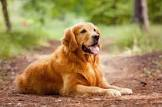

In [3]:

classes = ['Cachorro', 'Gato']

google = GoogleImages()
lista = google.pesquisar_lista(classes, 10)

# Mostra a primeira imagem
imagem1 = lista[classes[0]][0]
resposta = requests.get(imagem1)
img = PIL.Image.open(BytesIO(resposta.content))
img

In [8]:

def ler_imagem(link: str) -> PIL.Image:
    resposta = requests.get(link)
    resposta = BytesIO(resposta.content)
    img = PIL.Image.open(resposta)
    return img

# Convert image to 
def processar_imagem(img: PIL.Image) -> np.ndarray:
    img = img.resize((100, 100))
    X = keras.utils.img_to_array(img)
    X = X.flatten()
    return X

def processar_lista(lista: Dict[str, List[str]]) -> Tuple[np.ndarray, np.ndarray]:

    X = []
    y = []

    for categoria, lista in enumerate(lista.values()):

        for link in lista:
            
            try:
                img = ler_imagem(link)    
                x = processar_imagem(img)

                X.append(x)
                y.append(categoria)

            except:
                next

    #X = np.array(X)
    #y = np.array(y)

    return X, y


In [9]:
classes = ['Homem', 'Mulher', 'Criança',        # 1 
           'Animais', 'Construções', 'Objetos'  # 0
           ]

google = GoogleImages()
lista = google.pesquisar_lista(classes, 101)

X, y = processar_lista(lista)



In [ ]:
y_ok = np.where(y <= 2, 1, 0)       # Definindo o que sao humanos
X_ok = X                            # Transform data into 1D array 

print(X_ok.shape)
print(y_ok.shape)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_ok, y_ok, 
                                                    train_size=0.7, 
                                                    shuffle=True,
                                                    random_state=32)


# For dimensionality reduction
pca = PCA(0.95)
sts = StandardScaler()

# Standardize daa
sts.fit(X_train)
X_train = sts.transform(X_train)
X_test = sts.transform(X_test)

# PCA
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# Cross Validation
cv = KFold(n_splits=10, shuffle=True, random_state=32)

# Train model
model = LinearSVC(penalty='l2', loss='squared_hinge', max_iter=10000, dual='auto')
model.fit(X_train, y_train)

# Eval MCC for KFold
mcc = cross_val_score(model, X_test, y_test, cv=cv, scoring=make_scorer(matthews_corrcoef))
print(mcc)



In [ ]:

google = GoogleImages()
teste = google.pesquisar('Miguel Zanchettin')

# Mostra a primeira imagem
imagem1 = teste[0]
resposta = requests.get(imagem1)
img = PIL.Image.open(BytesIO(resposta.content))
img


In [ ]:

X_p = np.array([processar_imagem(ler_imagem(teste[0]))])
X_p = X_p.mean(axis=2).mean(axis=2)
X_p = sts.transform(X_p)
X_p = pca.transform(X_p)

model.predict(X_p)